<a href="https://www.kaggle.com/code/ehsanlord/tweets-sentiment-analysis-nlp-model-bilstm?scriptVersionId=193769323" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Data Set Description :
#### The Sentiment140 dataset features 1,600,000 tweets labeled for sentiment (0 = negative, 2 = neutral, 4 = positive). Each tweet includes an ID, date, query flag, user handle, and text.

#### A deep learning model will be used to predict sentiment from tweets

### 1. Import important Library 📚



In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from string import punctuation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense ,BatchNormalization

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 2. Loading & Preprocessing Data 👓

In [3]:
df = pd.read_csv('tweets.csv', encoding='ISO-8859-1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df=df.drop(['1467810369','Mon Apr 06 22:19:45 PDT 2009','NO_QUERY','_TheSpecialOne_'],axis=1)

In [5]:
df.columns = ['category', 'comment']


In [6]:
df

,category,comment
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
df["category"].value_counts()

,count
category,
4,800000
0,799999


In [8]:
df["category"]=df["category"].replace({4:1})

In [9]:
df["category"].value_counts()

,count
category,
1,800000
0,799999


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

def process_text(text):

    text = re.sub(r'@\w+\s?', '', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    tokens = word_tokenize(text)

    translator = str.maketrans('', '', punctuation)
    tokens = [w.translate(translator) for w in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w.lower() not in stop_words]

    tokens = [w for w in tokens if w.isalnum()]

    return ' '.join(tokens)

df['cleaned_text'] = df['comment'].apply(process_text)

df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
max_len_cleaned = df['text_length'].max()

print(df)
print("Maximum length of cleaned text:", max_len_cleaned)


[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.


         category                                            comment  \

0               0  is upset that he can't update his Facebook by ...   

1               0  @Kenichan I dived many times for the ball. Man...   

2               0    my whole body feels itchy and like its on fire    

3               0  @nationwideclass no, it's not behaving at all....   

4               0                      @Kwesidei not the whole crew    

...           ...                                                ...   

1599994         1  Just woke up. Having no school is the best fee...   

1599995         1  TheWDB.com - Very cool to hear old Walt interv...   

1599996         1  Are you ready for your MoJo Makeover? Ask me f...   

1599997         1  Happy 38th Birthday to my boo of alll time!!! ...   

1599998         1  happy #charitytuesday @theNSPCC @SparksCharity...   



                                              cleaned_text  text_length  

0        upset ca nt update Facebook texting mi

In [11]:
x=df['cleaned_text']
y=df['category']
y.shape

(1599999,)

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [13]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1279999,), (320000,), (1279999,), (320000,))

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [15]:
vocab_len = len(tokenizer.word_index) + 1

In [16]:
vocab_len

338142

In [17]:
encoded = tokenizer.texts_to_sequences(x_train)

In [18]:
padded = pad_sequences(encoded, maxlen=max_len_cleaned, padding='post')

In [19]:
encoded_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(encoded_test, maxlen=max_len_cleaned, padding='post')

In [27]:
padded_test.shape

(320000, 50)

### 3. Model

In [22]:
model = Sequential()

model.add(Embedding(input_dim=vocab_len, output_dim=100, input_length=max_len_cleaned))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.build(input_shape=(None, max_len_cleaned))

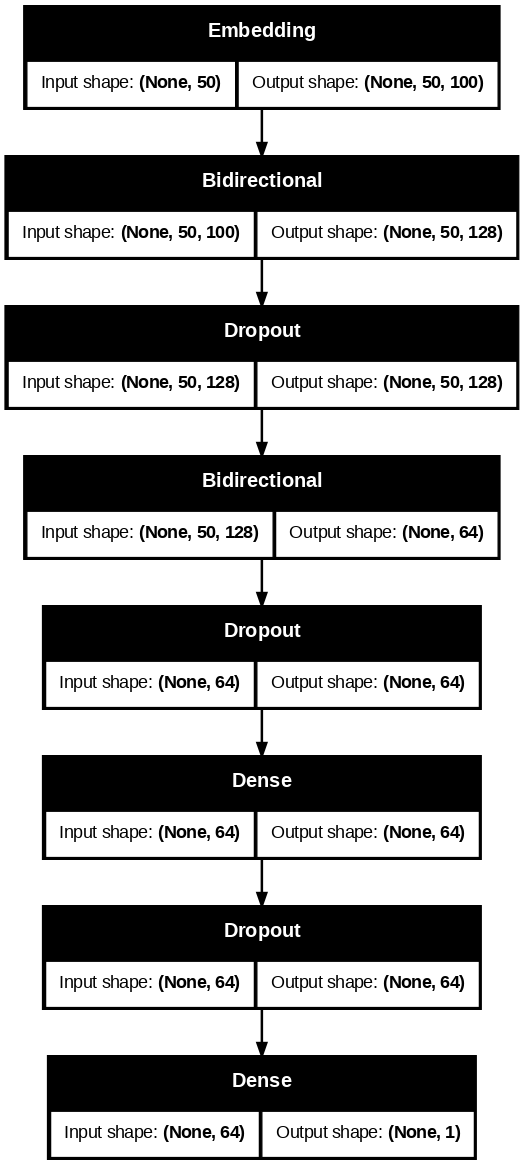

In [150]:
plot_model(model, show_shapes=True,dpi = 90)

In [151]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 100)             │      33,814,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,832,365 (388.46 MB)

 Trainable params: 33,944,121 (129.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,888,244 (258.97 MB)

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min')
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

In [30]:
history = model.fit(padded, y_train, epochs=10, batch_size=128, validation_data=[padded_test,y_test],callbacks=[lr,early])

Epoch 1/10

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 361s 35ms/step - accuracy: 0.7652 - loss: 0.4907 - val_accuracy: 0.7984 - val_loss: 0.4333 - learning_rate: 0.0010

Epoch 2/10

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 355s 35ms/step - accuracy: 0.8277 - loss: 0.3879 - val_accuracy: 0.7935 - val_loss: 0.4541 - learning_rate: 0.0010

Epoch 3/10

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 383s 36ms/step - accuracy: 0.8590 - loss: 0.3272 - val_accuracy: 0.7897 - val_loss: 0.4678 - learning_rate: 0.0010

Epoch 4/10

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 377s 35ms/step - accuracy: 0.8875 - loss: 0.2635 - val_accuracy: 0.7816 - val_loss: 0.5600 - learning_rate: 1.0000e-04


### 4. Model Metrics Visualization

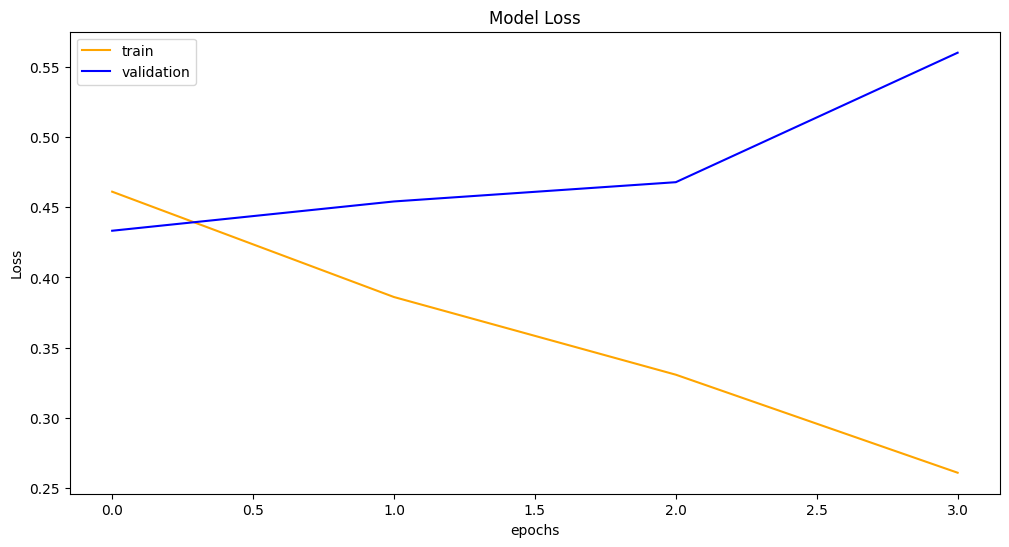

In [31]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'],c='orange')
plt.plot(history.history['val_loss'],c='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train','validation'])
plt.show()

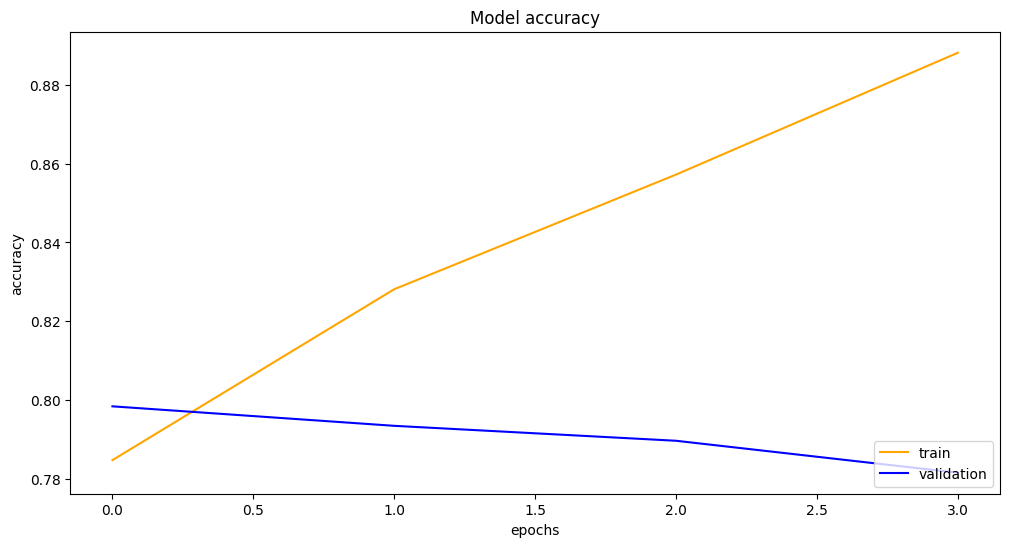

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'],c='orange')
plt.plot(history.history['val_accuracy'],c='b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='lower right')
plt.show()

### 5. Model Evaluation with test data

In [33]:
model.evaluate(padded_test,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.7982 - loss: 0.4333


[0.4332704246044159, 0.7984187602996826]

In [34]:
model.evaluate(padded,y_train)

40000/40000 ━━━━━━━━━━━━━━━━━━━━ 246s 6ms/step - accuracy: 0.8242 - loss: 0.3912


[0.3910890519618988, 0.8242920637130737]

In [35]:
y_pred=model.predict(padded_test)
y_pred=np.where(y_pred>0.5,1,0)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support



           0       0.80      0.79      0.80    159494

           1       0.80      0.81      0.80    160506



    accuracy                           0.80    320000

   macro avg       0.80      0.80      0.80    320000

weighted avg       0.80      0.80      0.80    320000




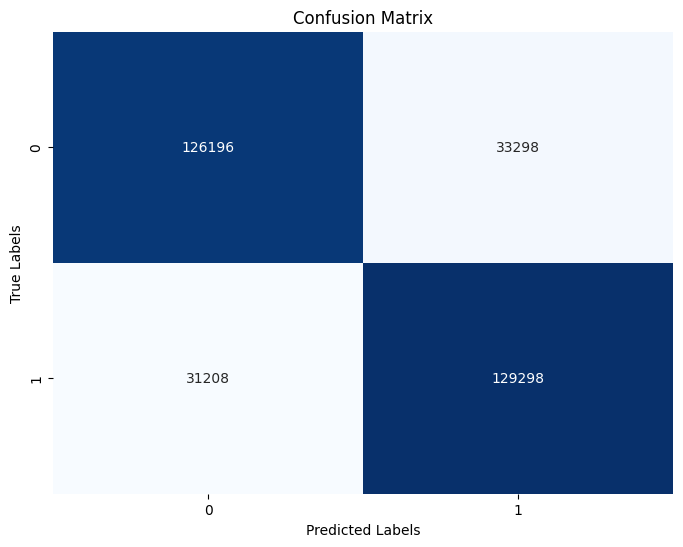

In [37]:
conf=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 6. get some predictions

In [149]:
def predictions(text):
    txt=text
    text=tokenizer.texts_to_sequences(text)
    text=pad_sequences(text,maxlen=max_len_cleaned)
    y_pred=model.predict(text)
    y_pred=np.where(y_pred>0.5,1,0)
    if y_pred[0] == 0:
        print(txt)
        print(y_pred[0])
        print('Negative')
    else:
        print(txt)
        print(y_pred[0])
        print('Positive')

predictions(df['cleaned_text'].sample(n=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1016596    thanks promoting dude really appreciate

Name: cleaned_text, dtype: object

[1]

Positive
